In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
def u2de(xp, t):
    if abs(t) < 1e-10:
        return 0
    return xp.x**2 + xp.y**2 + 4*t
    

In [3]:
def du2de(xb, t, rfunc, s):
    if abs(t) < 1e-10:
        return 0
    r_s = rfunc(s)
    nu = (-np.sin(s)/r_s, np.cos(s)/r_s)

    return 2*xb.x*nu[0] + 2*xb.y*nu[1]


In [4]:
T = 2 # final time
N = 9 # N+1=10 time points
# M = 64 # number of collocation points
# M = 16 # number of collocation points
M = 8 # number of collocation points

In [5]:
from gpbr.direct.common.collocation import collocation_points_2d, CollocationData2D
coll_2d = collocation_points_2d(M, startpoint=False)
coll_2d

CollocationData2D(n=8, theta=array([0.78539816, 1.57079633, 2.35619449, 3.14159265, 3.92699082,
       4.71238898, 5.49778714, 6.28318531]))

In [6]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
point_circle = starlike_circle_base(coll_2d)

Gamma1 = point_circle*0.5
Gamma2 = point_circle*1.5

In [7]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [8]:
import matplotlib.pyplot as plt

def plot_boundaries_and_points(G1: StarlikeCurve, G2: StarlikeCurve, test_points, t):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')
    for i, p in enumerate(test_points):
        ax_plot.plot(p.x, p.y, 'go')
        ax_plot.annotate(f'ue_i={u2de(p,t)}', (p.x, p.y), textcoords="offset points", xytext=(15,-5), ha='center')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

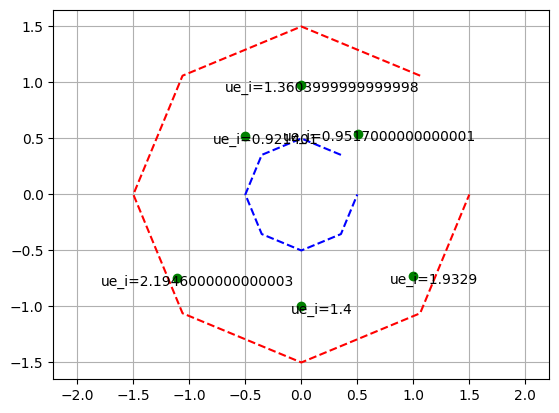

In [9]:
plot_boundaries_and_points(Gamma1, Gamma2, test_points,0.1)

# Approximation

In [10]:
tn = np.array([(n+1)*(T/(N+1)) for n in range(0, N+1)])
h = T/(N+1)

In [11]:
nu = np.sqrt(2/h)
nu

np.float64(3.1622776601683795)

In [12]:
betta_array = []
for n in range(0, N+1):
    sign = (-1)**n
    betta_array.append(sign*(4/h))
betta_array[0] = np.nan
betta_array

[nan, -20.0, 20.0, -20.0, 20.0, -20.0, 20.0, -20.0, 20.0, -20.0]

In [13]:
from gpbr.direct.heat_equation.common import MFSData
mfs_data =MFSData(N, T, tn, M, betta_array, nu)

In [14]:
from gpbr.direct.common.source import SourcePoints2D, source_points_2d
source_coll_2d = collocation_points_2d(M//2, startpoint=False)
source_point_circle = starlike_circle_base(source_coll_2d)
eta1 = 0.5
eta2 = 2.0


Gamma1_source = source_point_circle*0.5
Gamma2_source = source_point_circle*1.5

source_points = source_points_2d(eta1, eta2, Gamma1_source, Gamma2_source)

In [15]:
## Plot
import matplotlib.pyplot as plt
def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, artG1: StarlikeCurve, artG2: StarlikeCurve):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    art1_x, art1_y = artG1.raw_points()
    art2_x, art2_y = artG2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')
    ax_plot.plot(art1_x, art1_y, 'bo')
    ax_plot.plot(art2_x, art2_y, 'ro')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()


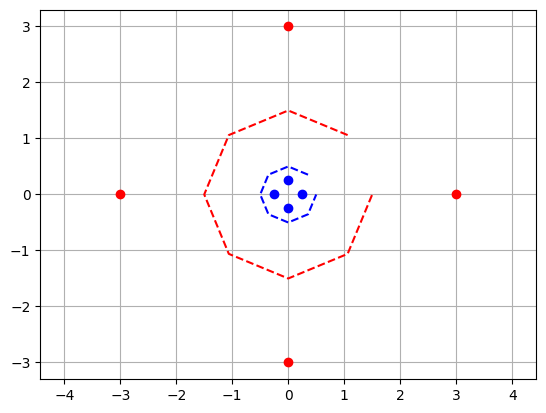

In [16]:
plot_2d(Gamma1, Gamma2, source_points.gart1, source_points.gart2)

In [17]:
from gpbr.direct.heat_equation.polynomial import MFSPolinomials2D, calculate_2d_polinomials

mfs_polynomyals = calculate_2d_polinomials(mfs_data, N)

In [18]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data, mfs_polynomyals)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data, mfs_polynomyals)

In [19]:
from gpbr.direct.common.boundary import Point2D, Point3D
from gpbr.direct.common.distance import point_distance


def f1(x: Point2D | Point3D , t):
    return u2de(x, t)
    # return 0

def f2(x: Point2D | Point3D, t: float) -> np.array:
    return u2de(x, t)
    # return (t**2)*np.exp(-4*t+2)*point_distance(x, Point2D(0,0))

In [20]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(16, 8)

In [21]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)

In [22]:
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    from numpy.linalg import lstsq
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[702.11814423 702.11814423 702.11814423 702.11814423   1.02922829
    1.02922829   1.02922829   1.02922829]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan          nan          nan          nan          nan
           nan          nan          nan]
 [         nan     

In [23]:
from gpbr.direct.heat_equation.helpers import u_2d

In [37]:
for p in test_points:
    print(u_2d(p, 0, source_points, fs_coefs, mfs_polynomyals, mfs_data))

0.751899815099707
0.5785264848466106
0.5608872533559035
0.5812801998173968
0.7020328465747149
0.7811857163132249


In [38]:
for p in test_points:
    print(u2de(p, 0.2))

1.7604
2.3329
1.3517000000000001
1.321401
2.5946000000000002
1.8
